In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

# Lecture 10

### Neural Network with :

Fashion MNIST


In [18]:
# Lets import some libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
%matplotlib inline


In [19]:
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random 

CMAP = plt.cm.bwr_r
# plt.rcParams.update(params)
# plt.set_cmap(CMAP)

plt.style.use('bmh')
    
EPOCHS = 100 # number of epochs
BATCH_SIZE = 32 # batch size
ALPHA = 0.001 # learning rate

ES_PATIENCE = 10 # if performance does not improve stop 
LR_PATIENCE = 5 # if performance is not improving reduce alpha
LR_FACTOR = 0.1 # rate of reduction of alpha

## Read Fashion DataSet

In [20]:
pwd

'c:\\Users\\user\\Desktop\\WORK\\Artificial Intelligence\\Neural Networks'

In [21]:
train_df = pd.read_csv('fashion-mnist_train.csv')
test_df = pd.read_csv('fashion-mnist_test.csv')

In [22]:
class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

In [23]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

In [24]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


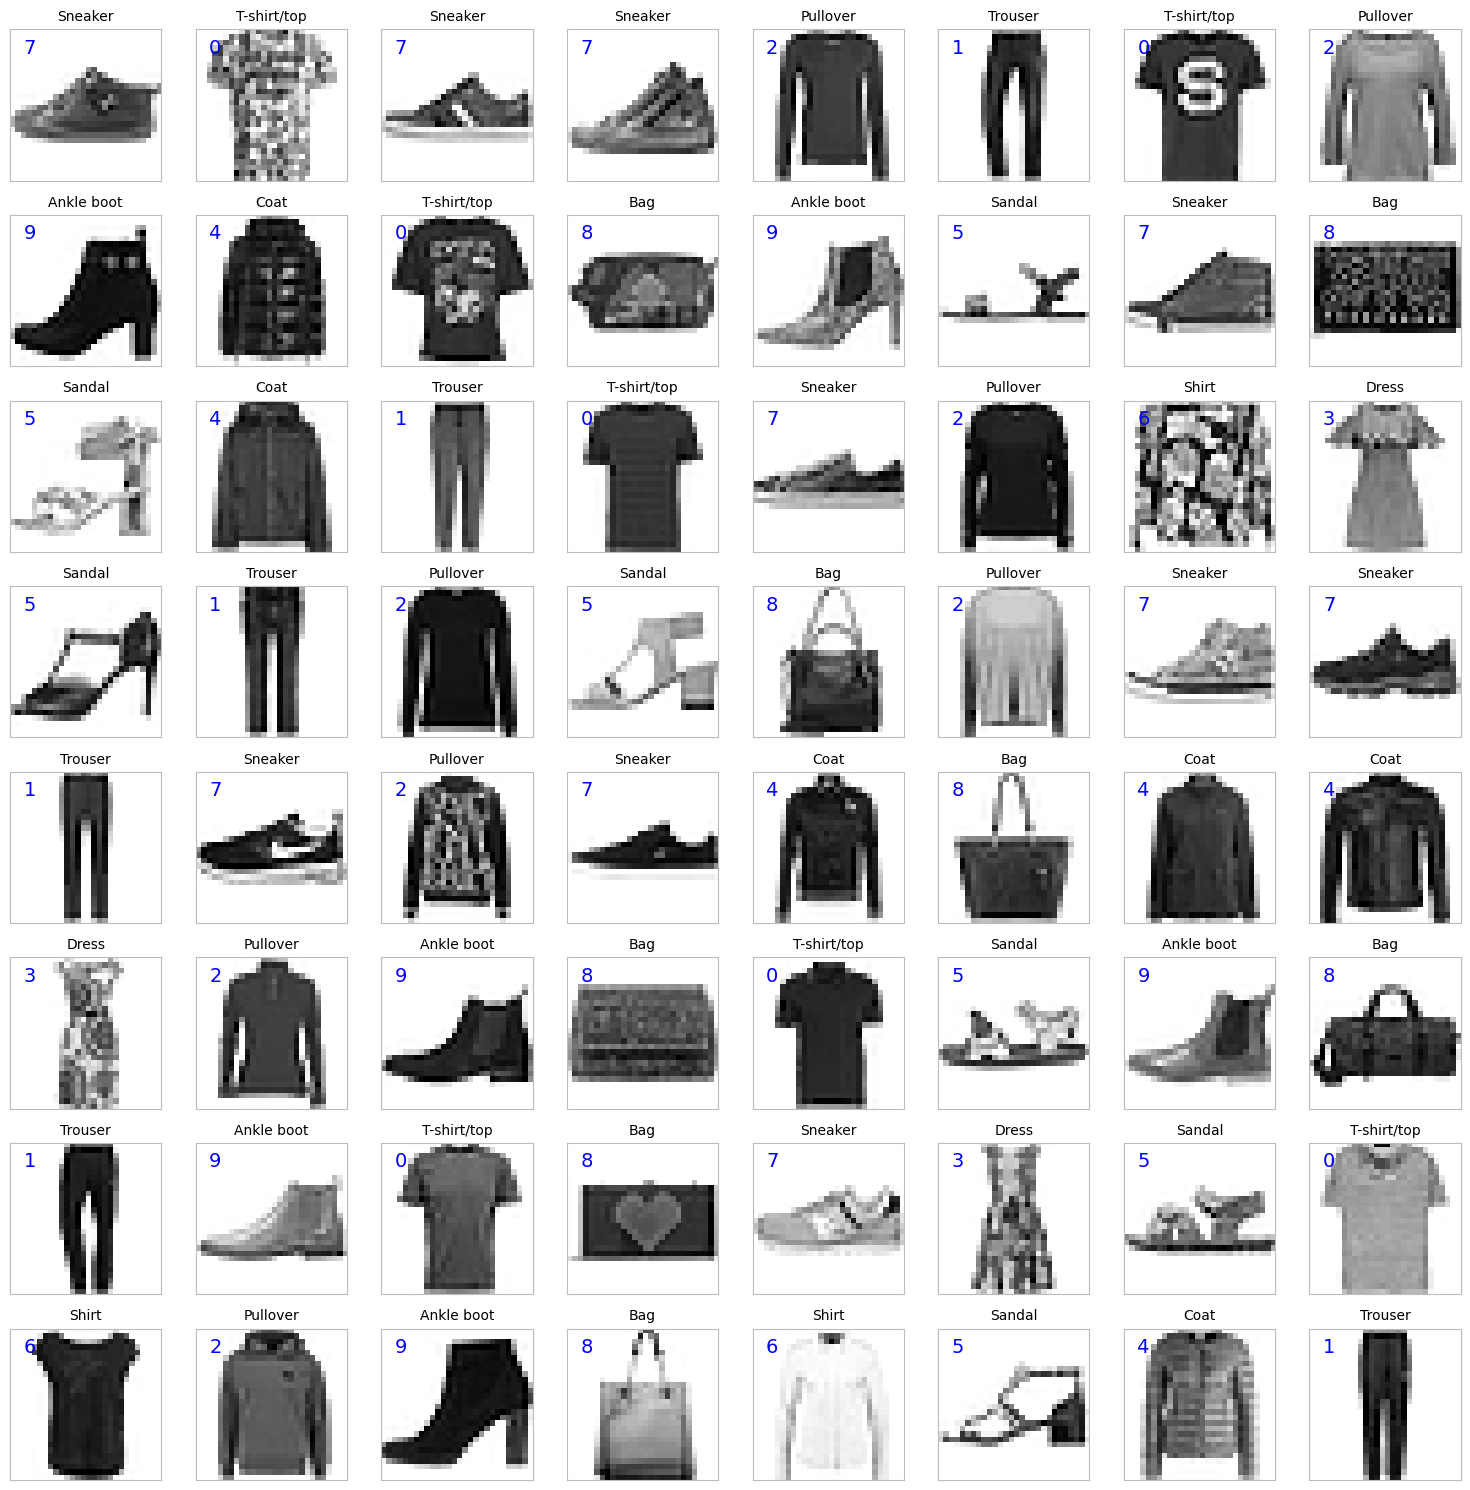

In [25]:
# Sample data plot

plot_df = train_df.sample(n = 64) # Take 100 sample from the training set

fig = plt.figure(figsize=(15, 15))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

for _ , row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:].reshape(28,28) # reshape row to a 28x28 matrix
    
    ax = fig.add_subplot(8, 8, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.text(2, 4, str(row.iloc[0]), color='b', fontsize=14)   # add number (class) of the image
    
    ax.set_title(class_names[row.iloc[0]], fontsize=10)   # add name of the image

plt.tight_layout() 
plt.show()

In [26]:
X_train = train_df.drop('label', axis=1).to_numpy()
y_train = train_df['label'].to_numpy()

X_test = test_df.drop('label', axis=1).to_numpy()
y_test = test_df['label'].to_numpy()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [27]:
X_train.max()

255

In [28]:
X_train = X_train / 255.0

X_test = X_test / 255.0

# Prepare Model
Build `tf.keras.Sequential` model model by taking `tf.keras.layers.Dense`

In [29]:
def build_model():
    #Dropout rates 
    dor1 = 0.25
    dor2 = 0.35
    # Regularization
    l_2=0.01

    model = tf.keras.Sequential([
    ###------
    ### Set 1
    ###------
    tf.keras.layers.Dense(784//2, 
        #kernel_regularizer = tf.keras.regularizers.L2(l2=l_2))
    ),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Dropout(dor1),
    
    ###------
    ### Set 2
    ###------
    tf.keras.layers.Dense(784//4, 
                        #kernel_regularizer = tf.keras.regularizers.L2(l2=l_2))
    ),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Dropout(dor1),
    
    
    ###------
    ### Set 3
    ###------
    tf.keras.layers.Dense(784//16, 
                        #kernel_regularizer = tf.keras.regularizers.L2(l2=l_2))
    ),
    
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Dropout(dor1),
    
    tf.keras.layers.Dense(10)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    return model

In [34]:
model = build_model()

In [35]:
predictions = model(X_train[:1])
predictions.numpy()

array([[ 0.2584022 , -0.27983147, -1.0887026 , -0.13427725, -0.01871456,
        -0.39273986, -0.08100062,  0.67305017, -0.1740325 , -0.05646769]],
      dtype=float32)

In [36]:
predictions = model(X_train[:1])
predictions.numpy().sum()

-1.294314

In [37]:
tf.nn.softmax(predictions).numpy().sum()

1.0000001

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 392)                  307720    
                                                                 
 batch_normalization (Batch  (1, 392)                  1568      
 Normalization)                                                  
                                                                 
 activation (Activation)     (1, 392)                  0         
                                                                 
 dropout (Dropout)           (1, 392)                  0         
                                                                 
 dense_1 (Dense)             (1, 196)                  77028     
                                                                 
 batch_normalization_1 (Bat  (1, 196)                  784       
 chNormalization)                                       

In [39]:
import sys
sys.float_info.max, sys.float_info.min

(1.7976931348623157e+308, 2.2250738585072014e-308)

In [40]:
np.log(sys.float_info.max)

709.782712893384

In [41]:
np.exp(709)

8.218407461554972e+307

In [42]:
np.exp(710)

C:\Users\user\AppData\Local\Temp\ipykernel_12048\574927170.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(710)


inf

In [43]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [44]:
y_test.shape

(10000,)

In [45]:
# print(y_test)

In [46]:
y_train[:1]

array([2], dtype=int64)

In [47]:
loss_fn(y_train[:1], predictions).numpy()

3.3490274

#### always  give ? to get code

In [48]:
# model.compile?

In [49]:
# model.fit?

## Compile the model:
- Loss Function
- Optimizer
- list metrices to monitor

## Fit the model
- Training features
- Training target
- validations
- batch size
- epochs

In [50]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
              loss=loss_fn,
              metrics=['accuracy'])


history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose='auto',
    validation_data=[X_test, y_test])

Epoch 1/100


1875/1875 [==============================] - 17s 7ms/step - loss: 0.6045 - accuracy: 0.7940 - val_loss: 0.3879 - val_accuracy: 0.8575
Epoch 2/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.4565 - accuracy: 0.8400 - val_loss: 0.3665 - val_accuracy: 0.8644
Epoch 3/100
1875/1875 [==============================] - 14s 8ms/step - loss: 0.4140 - accuracy: 0.8536 - val_loss: 0.3390 - val_accuracy: 0.8800
Epoch 4/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3824 - accuracy: 0.8638 - val_loss: 0.3166 - val_accuracy: 0.8829
Epoch 5/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3681 - accuracy: 0.8676 - val_loss: 0.3169 - val_accuracy: 0.8810
Epoch 6/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3500 - accuracy: 0.8753 - val_loss: 0.3228 - val_accuracy: 0.8807
Epoch 7/100
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3367 - accuracy: 0.8786 - val_loss: 0.2936

In [51]:
model.evaluate ( X_test,  y_test, verbose=2)

313/313 - 1s - loss: 0.3228 - accuracy: 0.9095 - 927ms/epoch - 3ms/step


[0.32281267642974854, 0.909500002861023]

In [52]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.604537,0.794050,0.387938,0.8575
1,0.456474,0.840050,0.366502,0.8644
2,0.413992,0.853583,0.339015,0.8800
3,0.382430,0.863850,0.316614,0.8829
4,0.368087,0.867583,0.316889,0.8810


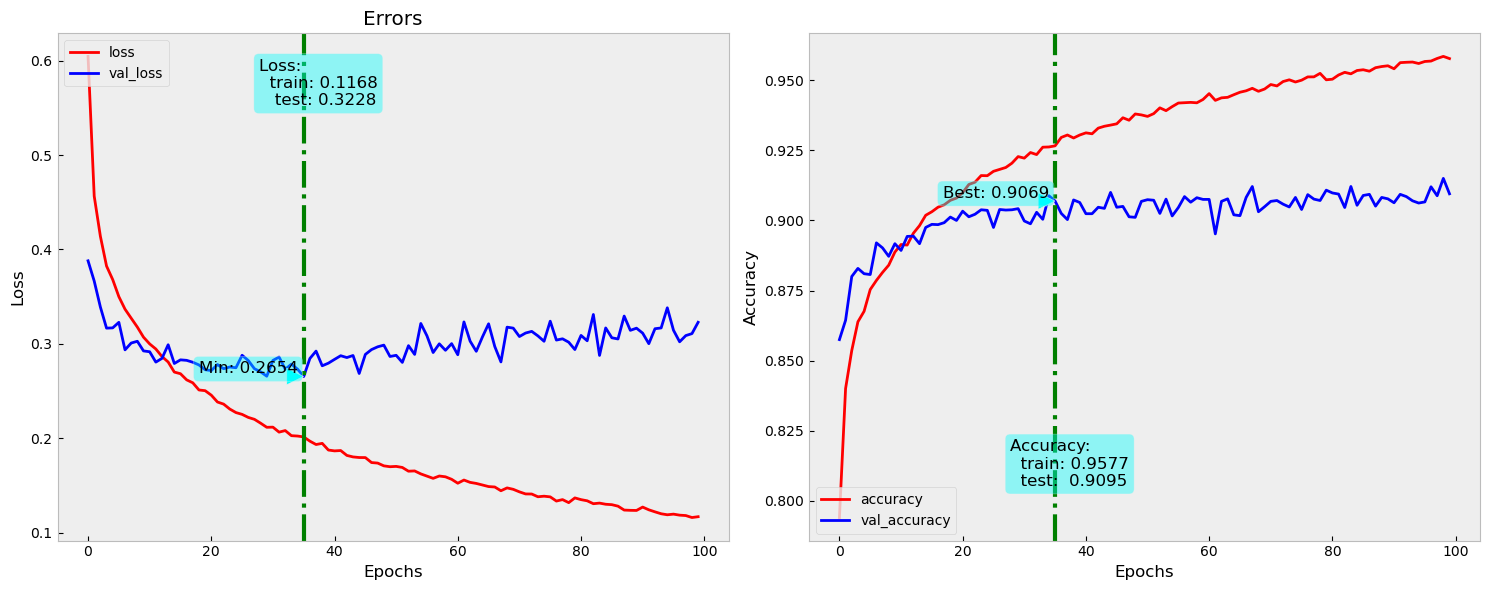

In [53]:
fig, axes = plt.subplots(1,2 , figsize = (15,6))

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
facecolor = 'cyan'
fontsize=12

# Get columns by index to eliminate any column naming error
y1 = hist_df.columns[0]
y2 = hist_df.columns[1]
y3 = hist_df.columns[2]
y4 = hist_df.columns[3]

# Where was min loss
best = hist_df[hist_df[y3] == hist_df[y3].min()]

ax = axes[0]

hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


# little beautification
txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                       hist_df.iloc[-1][y3]) #text to plot

# place a text box in upper middle in axes coords
ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

# Mark arrow at lowest
ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
            xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
            xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
            fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
            arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

# Draw vertical line at best value
ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

ax.set_xlabel("Epochs")
ax.set_ylabel(y1.capitalize())
ax.set_title('Errors')
ax.grid();
ax.legend(loc = 'upper left') # model legend to upper left

ax = axes[1]

hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)

# little beautification
txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                       hist_df.iloc[-1][y4]) #text to plot

# place a text box in upper middle in axes coords
ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
        verticalalignment='top', bbox=props)

# Mark arrow at lowest
ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
            xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
            xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
            fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
            arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


# Draw vertical line at best value
ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

ax.set_xlabel("Epochs")
ax.set_ylabel(y2.capitalize())
ax.grid()
ax.legend(loc = 'lower left')

plt.tight_layout()


In [54]:
y_pred = model.predict(X_train)
y_pred = y_pred.argmax(axis=1)
print('Accuracy score: ', accuracy_score(y_train, y_pred))

1875/1875 [==============================] - 7s 4ms/step
Accuracy score:  0.9825333333333334


In [55]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print('Accuracy score: ', accuracy_score(y_test, y_pred))

313/313 [==============================] - 1s 4ms/step
Accuracy score:  0.9095


In [56]:
# plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[866,   1,  16,  25,   1,   2,  83,   0,   6,   0],
       [  2, 990,   1,   5,   0,   1,   0,   0,   1,   0],
       [ 14,   1, 842,  14,  51,   1,  74,   0,   3,   0],
       [ 13,   8,  12, 934,  18,   1,  14,   0,   0,   0],
       [  0,   0,  74,  28, 826,   0,  70,   0,   2,   0],
       [  0,   0,   0,   0,   0, 963,   1,  27,   1,   8],
       [122,   3,  47,  26,  25,   0, 771,   0,   6,   0],
       [  0,   0,   0,   0,   0,   8,   0, 962,   0,  30],
       [  3,   0,   4,   2,   1,   2,   9,   1, 978,   0],
       [  0,   0,   0,   0,   0,   8,   0,  29,   0, 963]], dtype=int64)

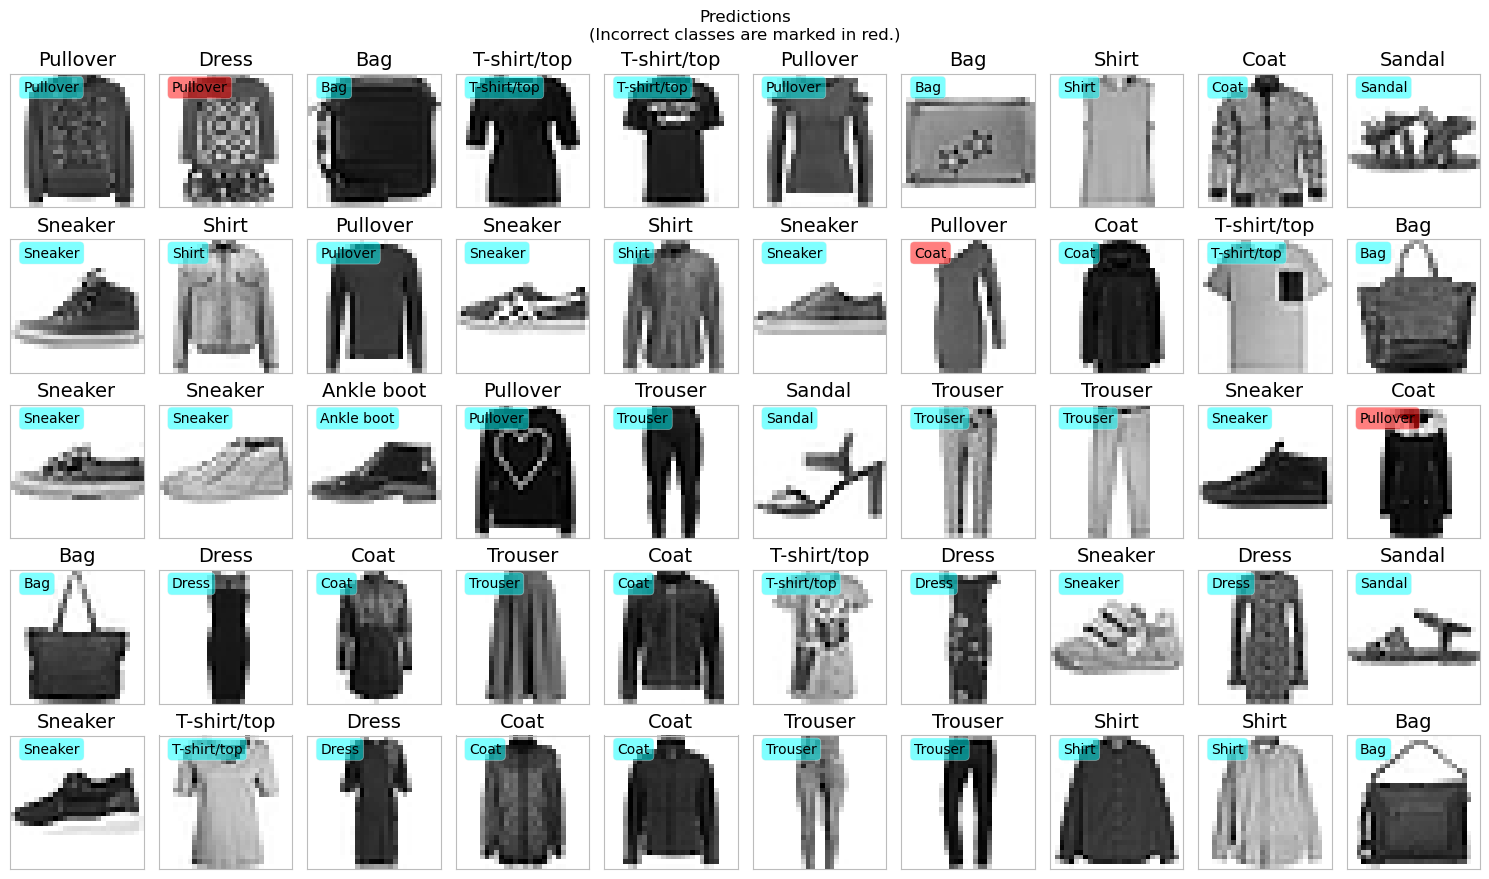

In [57]:
# Results data plot

test_df['y_pred'] = y_pred

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

i = 0

fntsize = 14

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row.iloc[0]!= row.iloc[-1]:
        color = 'red'
    else:
        color = 'cyan'

    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_title(class_names[row.iloc[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_names[row.iloc[-1]], transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\n(Incorrect classes are marked in red.)')
plt.tight_layout()
plt.show()